In [555]:
import torch
from torch import nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# 🧠 **Many Men vs Iron Man** 🧠

### Welcome to an Lesson 03! 🚀

In this notebook, we will pit an ensemble of 3 neural networks 👫👫👫 against 1 big neural network 💪 to see which performs better at identifying the state (REM, wakeful, deep) of a 10-second long segment of data.

Our data comes from **rats** 🐀 and includes 10-second long segments that are classified into one of three states: REM, wakeful, or deep sleep. By comparing these two approaches, we aim to determine whether the combined wisdom of many smaller models or the sheer power of a single large model will triumph.

Will the collective intelligence of many prevail, or will the might of a lone giant come out on top? Let's dive in and find out! 🔍⚡

In [556]:
DATA_FOLDER = './../data/rat_eeg'


files = [f for f in os.listdir(DATA_FOLDER) if f.endswith('.pt')]

all_data = []
for file in files:
    path = os.path.join(DATA_FOLDER, file)
    data = torch.load(path)
    all_data.append((data[0], data[1]))

# split  into train and test sets
train_data, test_data = train_test_split(all_data, test_size=2/6, random_state=42)

# concat to creat full set
X_train = torch.cat([data[0] for data in train_data])
y_train = torch.cat([data[1] for data in train_data])

X_test = torch.cat([data[0] for data in test_data])
y_test = torch.cat([data[1] for data in test_data])

print(f"Training  X: {X_train.shape}")
print(f"Training  y: {y_train.shape}\n")

print(f"Test X: {X_test.shape}")
print(f"Test y: {y_test.shape}")


Training  X: torch.Size([34560, 1000])
Training  y: torch.Size([34560, 3])

Test X: torch.Size([17280, 1000])
Test y: torch.Size([17280, 3])


### 🎵 Side Note 🎵

Can we code this whole thing up while listening to nothing but "Many Men"? 🤔🎶 I don't know, but I will keep you updated at eh end of the note book!


### ☯️ **Remember: Become One with the Data** ☯️

So let's take a look at some of it. 📊🔍


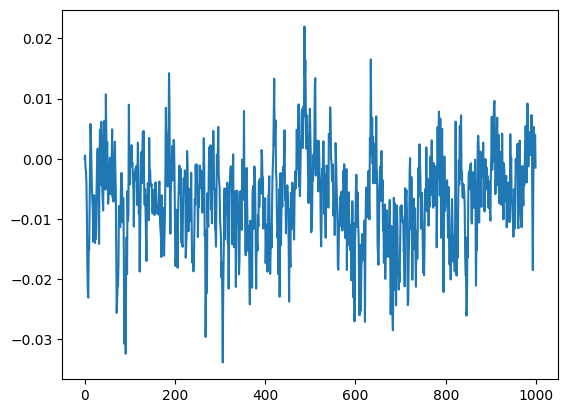

In [557]:
plt.plot(X_train[0])

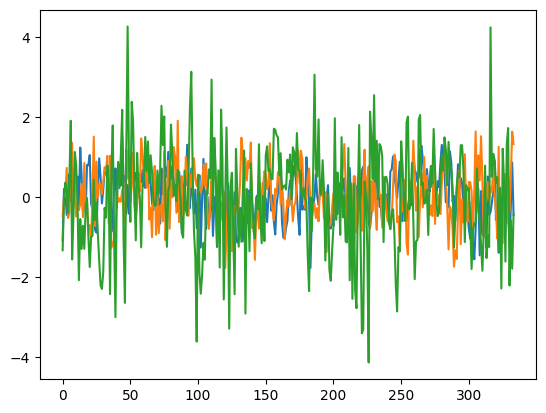

In [558]:
plt.plot(X_train[50, ::3]) #the  ::3 just plots ever 3 points
plt.plot(X_train[100, ::3])
plt.plot(X_train[1000, ::3])

In [559]:
y_train.argmax(axis=1).bincount() #coun of each lable

tensor([ 1782, 14050, 18728])

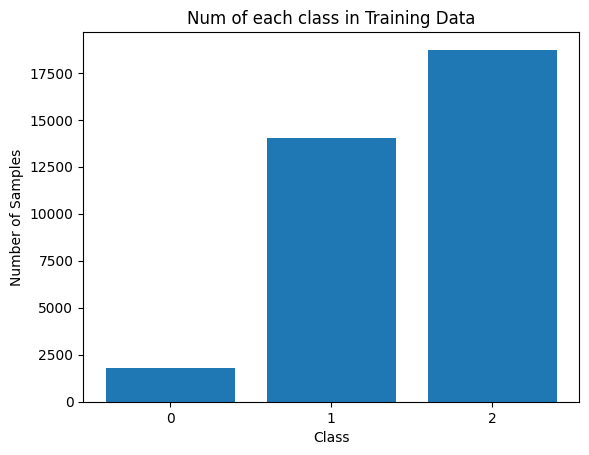

In [560]:
#so the range(len([?,?,?])) makes it such that there are 3 bins then second arg is the values in each bin
range_0_3 = range(len(y_train.argmax(axis=1).bincount()))

plt.bar(range_0_3, (y_train.argmax(axis=1).bincount()).numpy())

plt.title('Num of each class in Training Data');
plt.xlabel('Class');
plt.ylabel('Number of Samples');
plt.xticks(range_0_3);

### ⚖️ **The Issue of Unbalanced Data in ML** ⚖️

Our labels are not equal, which is a very big issue (☠️ some call it death ☠️) in machine learning. When we have a lot more of one type than another, we might classify everything as the dominant class because there's no penalty for getting the less frequent class wrong. This issue is inherent to our data, where class 0 (REM) is significantly underrepresented.

To address this, we will remove some samples from classes 1 and 2 to balance the dataset. There are many ways to solve this issue, but we will take this approach this time. However, note that deep learning fundamentally requires lots of data, so remove data cautiously. 🚨

Let's proceed and fix this imbalance! 🛠️

### 🚫 **No Augmentation for the Test Set** 🚫

It's important to note that we will not augment the test set in any way. This is because, in the real world, we would receive the data as it is, and we don't want to affect how we evaluate our performance. 📊🔍

Let's ensure our evaluation remains realistic and unbiased! ✅


In [561]:
#list of 3 tensors each tensor is the indices were the y_tarin is class = 0 then next tensor is the indices were the y_tarin is class = 1 etc........
class_indices = [torch.where(y_train.argmax(dim=1) == i)[0] for i in range(3)] 


max_samples = 1782  # num of REM samples

#of all the class 1 indices we do a random permutation then we get the first 1782 of the permutaion this now represents all the indices of the samples in the data set
class_indices[1] = class_indices[1][torch.randperm(len(class_indices[1]))[:max_samples]] 

#do the saw for class 2 
class_indices[2] = class_indices[2][torch.randperm(len(class_indices[2]))[:max_samples]]


print('count of each index is:')
len(class_indices[0]), len(class_indices[1]), len(class_indices[2])

count of each index is:


(1782, 1782, 1782)

In [562]:
balanced_indices = torch.cat(class_indices) #combine all of them 

# suffle then so the trian set is NOT jsut all rem then all class 1 then all class 2
balanced_indices = balanced_indices[torch.randperm(len(balanced_indices))]

# make the balanced datasets
X_train = X_train[balanced_indices]
y_train = y_train[balanced_indices]

print("new class counts:")
print(y_train.argmax(dim=1).bincount())

print(f"\nBalanced X_test shape: {X_train.shape}")
print(f"Balanced y_test shape: {y_train.shape}")

new class counts:
tensor([1782, 1782, 1782])

Balanced X_test shape: torch.Size([5346, 1000])
Balanced y_test shape: torch.Size([5346, 3])


### 🤔 **Less Data: A Good Idea?** 🤔

So, we have a lot less data now, and this might not have been a great idea. There are arguments both for and against this approach, but let's keep exploring and see what we find. 🔍

Stay curious and let's dive deeper! 🚀


So first, let's create a test neural network to see if we can memorize the data. 🧠💾

Remember over over fit first

In [563]:
class MLP_TESTER(nn.Module):
    def __init__(self):
        super(MLP_TESTER, self).__init__()
        self.l0  = nn.Linear(1000, 500)
        self.relu0 = nn.ReLU()

        self.l1  = nn.Linear(500, 100)
        self.relu1 = nn.ReLU()

        self.l2  = nn.Linear(100, 32)
        self.relu2 = nn.ReLU()

        self.l3  = nn.Linear(32, 32)
        self.relu3 = nn.ReLU()

        self.l4  = nn.Linear(32, 32)
        self.relu4 = nn.ReLU()

        self.l5  = nn.Linear(32, 32)
        self.relu5 = nn.ReLU()

        self.l6  = nn.Linear(32, 3)
        self.out = nn.Sigmoid()


    def forward(self, X):
        x = self.l0(X)
        x = self.relu0(x)
        x = self.l1(x)
        x = self.relu1(x)
        x = self.l2(x)
        x = self.relu2(x)
        x = self.l3(x)
        x = self.relu3(x)
        x = self.l4(x)
        x = self.relu4(x)
        x = self.l5(x)
        x = self.relu5(x)
        logits = self.l6(x)
        out = self.out(logits)
        return out

mlp_tester = MLP_TESTER()
optimizer = torch.optim.Adam(params=mlp_tester.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()

100%|██████████| 500/500 [00:11<00:00, 44.39it/s]


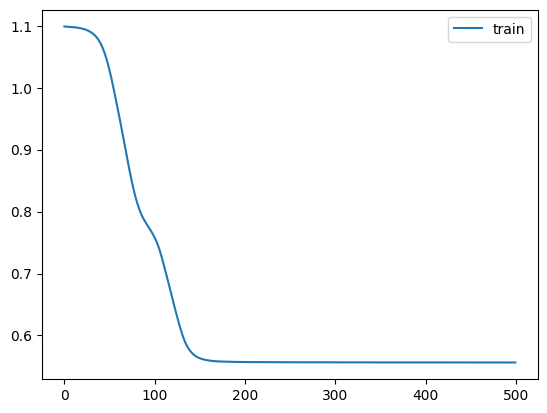

In [564]:
lossi = []

for epoch in tqdm(range(500)):
    out = mlp_tester.forward(X_train)

    optimizer.zero_grad()
    loss = criterion(out, y_train)

    loss.backward()
    lossi.append(loss.item())
    optimizer.step()

plt.plot(lossi, label='train')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1782
           1       1.00      0.99      0.99      1782
           2       0.99      1.00      0.99      1782

    accuracy                           1.00      5346
   macro avg       1.00      1.00      1.00      5346
weighted avg       1.00      1.00      1.00      5346



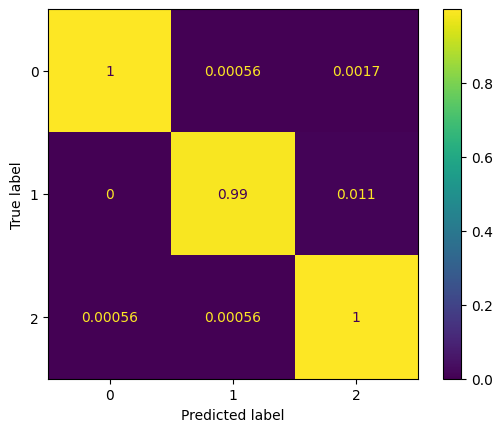

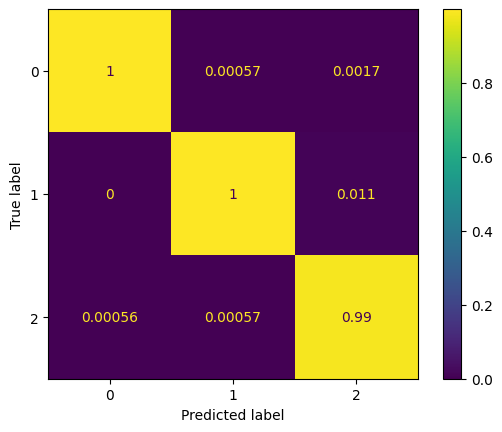

In [565]:
y_pred = mlp_tester.forward(X_train).argmax(axis=1);
y_true = y_train.argmax(axis=1);

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true');

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred');

print(classification_report(y_true=y_true, y_pred=y_pred));

### 🦾 **Iron Man Model: Let's Build It!** 🦾

Okay, perfect! We've overfitted the test model as intended. Now, let's make Iron Man.

We will use the same structure for Iron Man but introduce dropout with a rate of 0.3 to prevent overfitting and see if we can generalize better to the test set. Dropout is often compared to ensemble methods since we are dropping weights, effectively creating infinitely many different neural networks during training. I will make a lesson explaining dropout better sometime.

Let's get building! 🔨👷‍♂️


In [566]:
class IRONMAN(nn.Module):
    def __init__(self, dropout_rate=0.8):
        super(IRONMAN, self).__init__()
        self.l0 = nn.Linear(1000, 512)
        self.relu0 = nn.ReLU()
        self.dropout0 = nn.Dropout(dropout_rate)
        
        self.l1 = nn.Linear(512, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.l2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.l3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.l4 = nn.Linear(64, 32)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_rate)
        
        self.l5 = nn.Linear(32, 32)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(dropout_rate)
        
        self.l6 = nn.Linear(32, 3)
        self.out = nn.Sigmoid()

    def forward(self, X):
        x = self.dropout0(self.relu0(self.l0(X)))
        x = self.dropout1(self.relu1(self.l1(x)))
        x = self.dropout2(self.relu2(self.l2(x)))
        x = self.dropout3(self.relu3(self.l3(x)))
        x = self.dropout4(self.relu4(self.l4(x)))
        x = self.dropout5(self.relu5(self.l5(x)))
        logits = self.l6(x)
        x = self.out(logits)
        return x

ironman = IRONMAN()
optimizer = torch.optim.AdamW(params=ironman.parameters(), lr=0.0003, weight_decay=0.02)
criterion = nn.CrossEntropyLoss()

100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


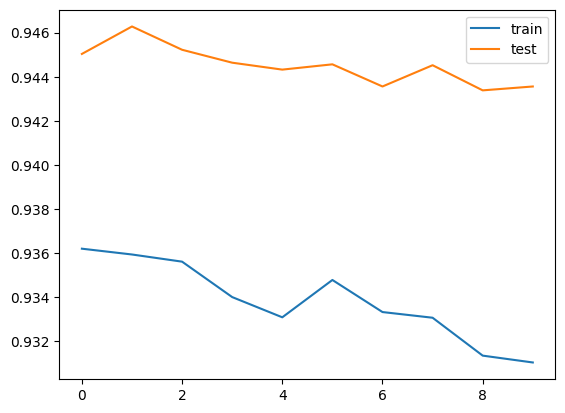

In [584]:
lossi = []
devlossi = []
f1 = []
devf1 = []

for epoch in tqdm(range(10)):
    out = ironman.forward(X_train)

    optimizer.zero_grad()
    loss = criterion(out, y_train)

    loss.backward()
    lossi.append(loss.item())
    optimizer.step()
    
    with torch.no_grad():
        devout = ironman.forward(X_test)
        devloss  = criterion(devout, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 1:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')
        plt.legend()
        plt.savefig("loss.png")



In [585]:
min(lossi), min(devlossi)

(0.9310473203659058, 0.9433811902999878)

              precision    recall  f1-score   support

           0       0.19      0.40      0.25      1075
           1       0.53      0.73      0.61      8122
           2       0.50      0.24      0.32      8083

    accuracy                           0.48     17280
   macro avg       0.41      0.45      0.40     17280
weighted avg       0.50      0.48      0.45     17280



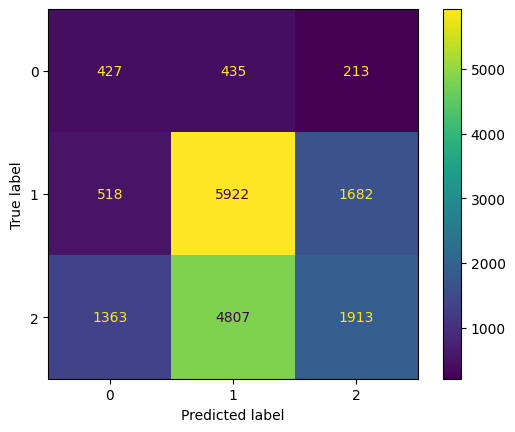

In [586]:
with torch.no_grad():
    y_pred = ironman.forward(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

#ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true')

#ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred')
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred)


print(classification_report(y_true=y_true, y_pred=y_pred))
